In [1]:
# PREPARE SCIKERAS DAN TENSOR
%pip uninstall tensorflow scikeras
%pip install tensorflow==2.12.0
%pip install scikeras==0.9.0

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
import pandas as pd

# Load the provided data
#file_path = '/content/drive/My Drive/intern/historical.csv'
#data = pd.read_csv(file_path)
data = pd.read_csv('D:/Akademik/PLN/historical.csv')

# Convert 'Datetime' to datetime objects
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

# Display the first few rows and summary statistics of the dataset
data_info = data.info()
data_head = data.head()
data_description = data.describe()

data_info, data_head, data_description

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9360 entries, 2024-01-09 00:30:00 to 2024-07-22 23:59:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Suhu    9360 non-null   float64
 1   MW      9360 non-null   float64
dtypes: float64(2)
memory usage: 219.4 KB


(None,
                       Suhu        MW
 Datetime                            
 2024-01-09 00:30:00  21.50  23206.91
 2024-01-09 01:00:00  21.30  22942.26
 2024-01-09 01:30:00  21.30  22793.85
 2024-01-09 02:00:00  21.55  22610.97
 2024-01-09 02:30:00  21.55  22419.90,
               Suhu            MW
 count  9360.000000   9360.000000
 mean     22.856448  25546.226328
 std       2.154657   3046.366198
 min      16.450000  14873.300000
 25%      21.250000  23438.132500
 50%      22.400000  25467.910000
 75%      24.650000  28170.247500
 max      28.250000  31329.910000)

In [3]:
df = data.copy()
df.shape

(9360, 2)

In [4]:
df.head()

,Suhu,MW
Datetime,,
2024-01-09 00:30:00,21.50,23206.91
2024-01-09 01:00:00,21.30,22942.26
2024-01-09 01:30:00,21.30,22793.85
2024-01-09 02:00:00,21.55,22610.97
2024-01-09 02:30:00,21.55,22419.90


In [5]:
# Split train test set
test_split=round(len(df)*0.20)
df_for_training=df[:-1041]
df_for_testing=df[-1041:]
print(df_for_training.shape)
print(df_for_testing.shape)

(8319, 2)
(1041, 2)


In [6]:
# Normalization
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.33823529, 0.50639895],
       [0.31862745, 0.49031726],
       [0.31862745, 0.481299  ],
       ...,
       [0.29411765, 0.5259297 ],
       [0.44117647, 0.55492048],
       [0.44117647, 0.62383869]])

# GRU


In [7]:
# Membuat sekuens
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i, 1])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,30)
testX,testY=createXY(df_for_testing_scaled,30)

In [8]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (8289, 30, 2)
trainY Shape--  (8289,)


In [9]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (1011, 30, 2)
testY Shape--  (1011,)


In [10]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.33823529 0.50639895]
 [0.31862745 0.49031726]
 [0.31862745 0.481299  ]
 [0.34313725 0.47018614]
 [0.34313725 0.45857561]
 [0.32843137 0.44214695]
 [0.32843137 0.45142712]
 [0.32352941 0.45842977]
 [0.32352941 0.49566648]
 [0.31862745 0.52695847]
 [0.31862745 0.55334969]
 [0.3627451  0.5362362 ]
 [0.3627451  0.52933867]
 [0.53431373 0.52660299]
 [0.53431373 0.59723722]
 [0.62254902 0.65010412]
 [0.62254902 0.71629333]
 [0.75       0.74443765]
 [0.75       0.77472639]
 [0.85294118 0.80948446]
 [0.85294118 0.82070913]
 [0.89215686 0.82669395]
 [0.89215686 0.82135142]
 [0.75       0.76782764]
 [0.75       0.77344727]
 [0.74509804 0.81729773]
 [0.74509804 0.86774068]
 [0.75490196 0.8745817 ]
 [0.75490196 0.87214378]
 [0.59313725 0.85417531]]
trainY[0]--  0.8594418899153593


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Build the LSTM Model
def create_gru_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Single output for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


model = KerasRegressor(build_fn=create_gru_model, verbose=0)
param_grid = {
    'units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [16, 32],
    'epochs': [40, 60]
}


grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(trainX, trainY)
best_model = grid_result.best_estimator_.model
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



C:\Users\fatih\AppData\Local\Temp\ipykernel_50620\1163741390.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_gru_model, verbose=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END batch_size=16, dropout_rate=0.2, epochs=40, units=50; total time= 2.2min
[CV] END batch_size=16, dropout_rate=0.2, epochs=40, units=50; total time= 2.1min
[CV] END batch_size=16, dropout_rate=0.2, epochs=40, units=50; total time= 2.3min
[CV] END batch_size=16, dropout_rate=0.2, epochs=40, units=100; total time= 2.8min
[CV] END batch_size=16, dropout_rate=0.2, epochs=40, units=100; total time= 2.5min
[CV] END batch_size=16, dropout_rate=0.2, epochs=40, units=100; total time= 3.2min
[CV] END batch_size=16, dropout_rate=0.2, epochs=40, units=150; total time= 6.0min
[CV] END batch_size=16, dropout_rate=0.2, epochs=40, units=150; total time= 7.0min
[CV] END batch_size=16, dropout_rate=0.2, epochs=40, units=150; total time= 6.6min
[CV] END batch_size=16, dropout_rate=0.2, epochs=60, units=50; total time= 3.4min
[CV] END batch_size=16, dropout_rate=0.2, epochs=60, units=50; total time= 3.6min
[CV] END batch_size=16, dropou

In [50]:
from sklearn.metrics import r2_score

# Prediksi menggunakan model pada data pengujian
y_pred_gru = best_model.predict(testX)

# hasil estimasi/ prediksi menggunakan Xtest (reverse)
gru_prediction_copies_array = np.repeat(y_pred_gru,2, axis=-1)
gru_pred=scaler.inverse_transform(np.reshape(gru_prediction_copies_array,(len(y_pred_gru),2)))[:,1]

original_copies_array = np.repeat(testY,2, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),2)))[:,1]

print("Pred Values-- " ,gru_pred)
print("\nOriginal Values-- " ,original)


# Metric score
mae_gru = mean_absolute_error(original, gru_pred)
mse_gru= mean_squared_error(original, gru_pred)
rmse_gru= np.sqrt(mse_gru)
mape_gru= np.mean(np.abs((original - gru_pred) / original)) * 100
r2_gru = r2_score(original, gru_pred)

print(f"R2 gru: {r2_gru}")
print(f"MAE gru: {mae_gru}")
print(f"MSE gru: {mse_gru}")
print(f"RMSE gru: {rmse_gru}")
print(f"MAPE in % gru: {mape_gru}")

32/32 [==============================] - 0s 11ms/step


ValueError: the 'axis' parameter is not supported in the pandas implementation of repeat()

In [53]:
# Check the length of original and gru_pred
print(f"Length of original: {len(original)}")
print(f"Length of gru_pred: {len(gru_pred)}")

Length of original: 1041
Length of gru_pred: 1011


In [54]:
import numpy as np

# Ensure testY is a NumPy array
testY = np.array(testY)  # Convert testY to a NumPy array if it's not already one

# Prediksi menggunakan model pada data pengujian
y_pred_gru = best_model.predict(testX)

# hasil estimasi/ prediksi menggunakan Xtest (reverse)
gru_prediction_copies_array = np.repeat(y_pred_gru, 2, axis=-1)
gru_pred = scaler.inverse_transform(np.reshape(gru_prediction_copies_array, (len(y_pred_gru), 2)))[:, 1]

# Safeguard to ensure testY is a NumPy array
if not isinstance(testY, np.ndarray):
    testY = np.array(testY)

original_copies_array = np.repeat(testY, 2, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), 2)))[:, 1]

print("Pred Values-- ", gru_pred)
print("\nOriginal Values-- ", original)

# Ensure both arrays have the same length
min_len = min(len(original), len(gru_pred))
original = original[:min_len]
gru_pred = gru_pred[:min_len]

# Now you can safely calculate the metrics
mae_gru = mean_absolute_error(original, gru_pred)
mse_gru = mean_squared_error(original, gru_pred)
rmse_gru = np.sqrt(mse_gru)
mape_gru = np.mean(np.abs((original - gru_pred) / original)) * 100
r2_gru = r2_score(original, gru_pred)

print(f"R2 gru: {r2_gru}")
print(f"MAE gru: {mae_gru}")
print(f"MSE gru: {mse_gru}")
print(f"RMSE gru: {rmse_gru}")
print(f"MAPE in % gru: {mape_gru}")


32/32 [==============================] - 0s 12ms/step
Pred Values--  [25959.98  25441.209 25192.014 ... 25754.553 25012.568 24856.771]

Original Values--  [2.83024202e+22 2.83024498e+22 2.83024794e+22 ... 2.83331677e+22
 2.83331973e+22 2.83332260e+22]
R2 gru: -10729012.671174325
MAE gru: 2.831737921346828e+22
MSE gru: 8.018740402582056e+44
RMSE gru: 2.8317380533132043e+22
MAPE in % gru: 100.0


In [55]:
# Mengidentifikasi tipe data
print("Tipe data original:", type(original))
print("Tipe data gru_pred:", type(gru_pred))

# Jika original dan gru_pred adalah numpy array, Anda bisa melihat tipe elemen dalam array
if isinstance(original, np.ndarray):
    print("Tipe elemen dalam original:", original.dtype)

if isinstance(gru_pred, np.ndarray):
    print("Tipe elemen dalam gru_pred:", gru_pred.dtype)

Tipe data original: <class 'numpy.ndarray'>
Tipe data gru_pred: <class 'numpy.ndarray'>
Tipe elemen dalam original: float64
Tipe elemen dalam gru_pred: float32


In [56]:
print("Isi original:", original)
print("Isi gru_pred:", gru_pred)

Isi original: [2.83024202e+22 2.83024498e+22 2.83024794e+22 ... 2.83322790e+22
 2.83323087e+22 2.83323383e+22]
Isi gru_pred: [25959.98  25441.209 25192.014 ... 25754.553 25012.568 24856.771]


In [60]:
datetime_array = df_for_testing.index
datetime_array = datetime_array[:len(original)]

print("Panjang original:", len(original))
print("Panjang gru_pred:", len(gru_pred))
print("Panjang datetime_array:", len(datetime_array))

Panjang original: 1011
Panjang gru_pred: 1011
Panjang datetime_array: 1011


In [62]:
datetime_array = df_for_testing.index
datetime_array = datetime_array[:len(original)]
max_len = max(len(original), len(gru_pred), len(datetime_array))

# Print the lengths of all arrays before adjusting
print(f"Length of original: {len(original)}")
print(f"Length of gru_pred: {len(gru_pred)}")
print(f"Length of datetime_array: {len(datetime_array)}")
print(f"Max length: {max_len}")

mape_values = np.abs((original - gru_pred) / original) * 100
rmse_values = np.sqrt((original - gru_pred) ** 2)

# Adjust the length of datetime_array if necessary
if len(datetime_array) < max_len:
    datetime_array = datetime_array.append([datetime_array[-1]] * (max_len - len(datetime_array)))
elif len(datetime_array) > max_len:
    datetime_array = datetime_array[:max_len]

# Print the lengths again after adjustments
print(f"Adjusted length of datetime_array: {len(datetime_array)}")
print(f"Length of original after adjustment: {len(original)}")
print(f"Length of gru_pred after adjustment: {len(gru_pred)}")
print(f"Length of MAPE values: {len(mape_values)}")
print(f"Length of RMSE values: {len(rmse_values)}")

# Create the DataFrame
results_df = pd.DataFrame({
    'datetime': datetime_array,
    'actual': original,
    'prediction': gru_pred,
    'MAPE (%)': mape_values,
    'RMSE (MW)': rmse_values
})

# Simpan hasil prediksi dan model
results_df.to_csv('gru_prediction_results.csv', index=False)
best_model.save('gru_model.h5')
results_df.head()


Length of original: 1011
Length of gru_pred: 1011
Length of datetime_array: 1011
Max length: 1011
Adjusted length of datetime_array: 1011
Length of original after adjustment: 1011
Length of gru_pred after adjustment: 1011
Length of MAPE values: 1011
Length of RMSE values: 1011


,datetime,actual,prediction,MAPE (%),RMSE (MW)
0,2024-07-01 08:00:00,2.830242e+22,25959.980469,100.0,2.830242e+22
1,2024-07-01 08:30:00,2.830245e+22,25441.208984,100.0,2.830245e+22
2,2024-07-01 09:00:00,2.830248e+22,25192.013672,100.0,2.830248e+22
3,2024-07-01 09:30:00,2.830251e+22,24444.119141,100.0,2.830251e+22
4,2024-07-01 10:00:00,2.830254e+22,24322.316406,100.0,2.830254e+22


ValueError: All arrays must be of the same length

In [64]:
# Convert the first (and only) element of the list to a NumPy array
orig = np.array(original.split(', '), dtype=float)
grupred = np.array(gru_pred.split(', '), dtype=float)
datetime_array =testY.index
datetime_array = datetime_array[:len(original)]
results_df = pd.DataFrame({
    'datetime': datetime_array,
    'actual': original,
    'prediction': gru_pred,
    'MAPE (%)': mape_values,
    'RMSE (MW)': rmse_values
})

# Save prediksi dan model
results_df.to_csv('gru_prediction_results.csv', index=False)
best_model.save('gru_model.h5')
results_df.head()

AttributeError: 'numpy.ndarray' object has no attribute 'split'

# LSTM

In [14]:
historical_df = data.copy()

# Create lagged features
for lag in range(1, 25):
    historical_df[f'Suhu(t-{lag})'] = historical_df['Suhu'].shift(lag)
    historical_df[f'MW(t-{lag})'] = historical_df['MW'].shift(lag)

# Add rolling statistics
historical_df['RollingMean_3'] = historical_df['MW'].rolling(window=3).mean()
historical_df['RollingStd_3'] = historical_df['MW'].rolling(window=3).std()

# Drop rows with NaN values (due to lagging)
historical_df = historical_df.dropna()

# Display the prepared DataFrame
print(historical_df.head())

                      Suhu        MW  Suhu(t-1)   MW(t-1)  Suhu(t-2)  \
Datetime                                                               
2024-01-09 12:30:00  25.70  27601.62      25.70  27509.14      27.15   
2024-01-09 13:00:00  25.65  28323.25      25.70  27601.62      25.70   
2024-01-09 13:30:00  25.65  29153.37      25.65  28323.25      25.70   
2024-01-09 14:00:00  25.75  29265.95      25.65  29153.37      25.65   
2024-01-09 14:30:00  25.75  29225.83      25.75  29265.95      25.65   

                      MW(t-2)  Suhu(t-3)   MW(t-3)  Suhu(t-4)   MW(t-4)  ...  \
Datetime                                                                 ...   
2024-01-09 12:30:00  28389.96      27.15  28477.88      26.75  28379.39  ...   
2024-01-09 13:00:00  27509.14      27.15  28389.96      27.15  28477.88  ...   
2024-01-09 13:30:00  27601.62      25.70  27509.14      27.15  28389.96  ...   
2024-01-09 14:00:00  28323.25      25.70  27601.62      25.70  27509.14  ...   
2024-01-09 14:3

In [15]:
historical_df.describe()

,Suhu,MW,Suhu(t-1),MW(t-1),Suhu(t-2),MW(t-2),Suhu(t-3),MW(t-3),Suhu(t-4),MW(t-4),...,Suhu(t-21),MW(t-21),Suhu(t-22),MW(t-22),Suhu(t-23),MW(t-23),Suhu(t-24),MW(t-24),RollingMean_3,RollingStd_3
count,9336.000000,9336.000000,9336.000000,9336.000000,9336.000000,9336.00000,9336.000000,9336.000000,9336.000000,9336.000000,...,9336.000000,9336.000000,9336.000000,9336.000000,9336.000000,9336.000000,9336.000000,9336.000000,9336.000000,9336.000000
mean,22.855275,25548.181854,22.856084,25548.436313,22.857053,25548.73144,22.858023,25548.996610,22.858917,25549.173314,...,22.861675,25540.242469,22.861247,25539.513847,22.860818,25538.913896,22.860433,25538.420800,25548.449869,353.490436
std,2.154363,3047.846443,2.154014,3047.910987,2.153910,3048.05273,2.153805,3048.199871,2.153687,3048.316137,...,2.152261,3045.735893,2.152174,3045.579136,2.152087,3045.539020,2.152008,3045.543876,3027.905793,239.975718
min,16.450000,14873.300000,16.450000,14873.300000,16.450000,14873.30000,16.450000,14873.300000,16.450000,14873.300000,...,16.450000,14873.300000,16.450000,14873.300000,16.450000,14873.300000,16.450000,14873.300000,14927.360000,0.958454
25%,21.250000,23439.482500,21.250000,23439.482500,21.250000,23439.48250,21.250000,23439.482500,21.250000,23439.482500,...,21.250000,23436.882500,21.250000,23435.812500,21.250000,23435.415000,21.250000,23434.622500,23465.191667,177.648817
50%,22.400000,25469.675000,22.400000,25470.585000,22.400000,25470.58500,22.400000,25470.585000,22.400000,25470.585000,...,22.400000,25460.255000,22.400000,25459.250000,22.400000,25458.175000,22.400000,25457.880000,25476.790000,296.273809
75%,24.650000,28172.747500,24.650000,28172.747500,24.650000,28174.17500,24.650000,28174.667500,24.650000,28175.657500,...,24.650000,28163.312500,24.650000,28162.087500,24.650000,28160.820000,24.650000,28160.820000,28171.261667,493.155813
max,28.250000,31329.910000,28.250000,31329.910000,28.250000,31329.91000,28.250000,31329.910000,28.250000,31329.910000,...,28.250000,31329.910000,28.250000,31329.910000,28.250000,31329.910000,28.250000,31329.910000,31136.440000,1775.152126


In [ ]:
# Define features and target
features = historical_df.drop(columns=['MW'])
target = historical_df['MW']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Scale the Data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape data for LSTM [samples, timesteps, features]
SEQ_LENGTH = 1
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], SEQ_LENGTH, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], SEQ_LENGTH, X_test_scaled.shape[1]))


# Check the shape after reshaping
print("X_train_scaled shape after reshaping:", X_train_scaled.shape)
print("X_test_scaled shape after reshaping:", X_test_scaled.shape)

X_train_scaled shape after reshaping: (7468, 1, 51)
X_test_scaled shape after reshaping: (1868, 1, 51)


Epoch 1/100
234/234 [==============================] - 7s 12ms/step - loss: 0.0377 - val_loss: 0.0027 - lr: 0.0010
Epoch 2/100
234/234 [==============================] - 2s 8ms/step - loss: 0.0071 - val_loss: 0.0017 - lr: 0.0010
Epoch 3/100
234/234 [==============================] - 2s 7ms/step - loss: 0.0046 - val_loss: 0.0025 - lr: 0.0010
Epoch 4/100
234/234 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0033 - lr: 0.0010
Epoch 5/100
234/234 [==============================] - 1s 5ms/step - loss: 0.0029 - val_loss: 0.0017 - lr: 0.0010
Epoch 6/100
234/234 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 0.0016 - lr: 0.0010
Epoch 7/100
234/234 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0010 - lr: 0.0010
Epoch 8/100
234/234 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0011 - lr: 0.0010
Epoch 9/100
234/234 [==============================] - 1s 5ms/step - loss: 0.0016 - val

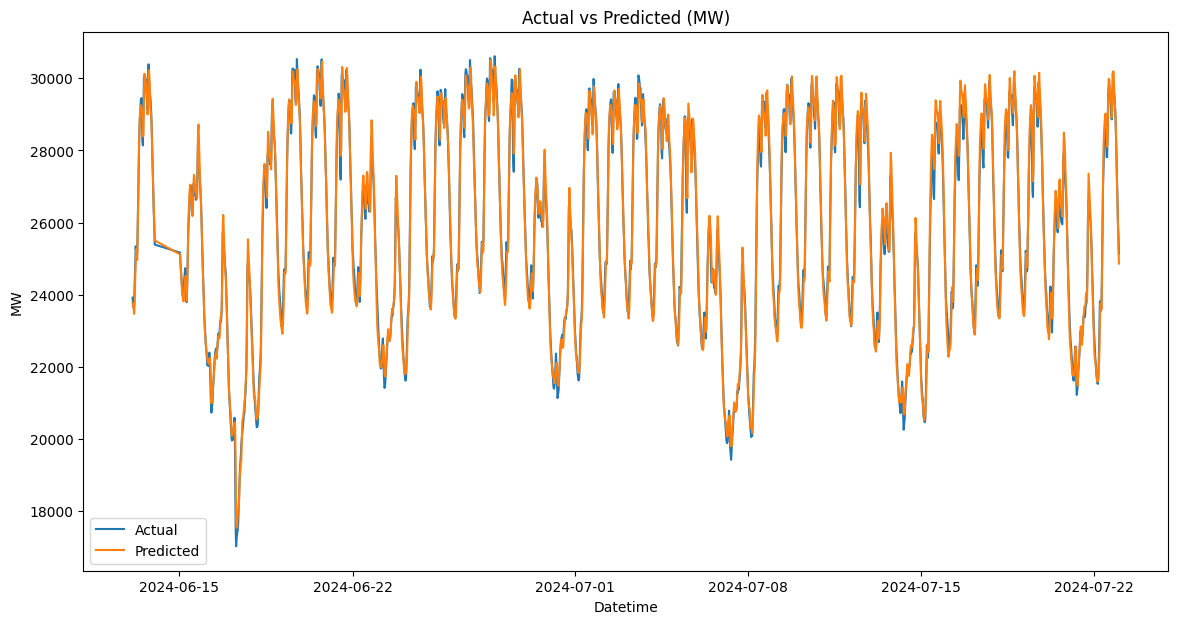

In [ ]:
# 3. Build the LSTM Model
model2 = Sequential()
model2.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train_scaled.shape[2])))
model2.add(Dropout(0.3))
model2.add(LSTM(50, return_sequences=False))
model2.add(Dropout(0.3))
model2.add(Dense(25, activation='relu'))
model2.add(Dense(1, activation='linear'))

model2.compile(optimizer='adam', loss='mean_squared_error')

# 4. Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# 5. Train the Model
history = model2.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 6. Make Predictions on the Test Set
y_pred_scaled = model2.predict(X_test_scaled)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)

# 7. Evaluate the Model
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

r2_lstm = r2_score(y_test_actual, y_pred_lstm)
mae_lstm= mean_absolute_error(y_test_actual, y_pred_lstm)
mse_lstm= mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm= np.sqrt(mse_lstm)
mape_lstm= np.mean(np.abs((y_test_actual - y_pred_lstm) / y_test_actual)) * 100

print(f"R2 lstm: {r2_lstm}")
print(f"MAE lstm: {mae_lstm}")
print(f"MSE lstm: {mse_lstm}")
print(f"RMSE lstm: {rmse_lstm}")
print(f"MAPE lstm: {mape_lstm}%")


plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test_actual, label='Actual')
plt.plot(y_test.index, y_pred_lstm, label='Predicted')
plt.title('Actual vs Predicted (MW)')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend()
plt.show()


In [ ]:
y_test_actual = y_test_actual.flatten()
y_pred_lstm = y_pred_lstm.flatten()

mape_values = np.abs((y_test_actual - y_pred_lstm) / y_test_actual) * 100
rmse_values = np.sqrt((y_test_actual - y_pred_lstm) ** 2)

results_df = pd.DataFrame({
    'datetime': y_test.index,
    'actual': y_test_actual,
    'estimation': y_pred_lstm,
    'MAPE (%)': mape_values,
    'RMSE (MW)': rmse_values
})


results_df.to_csv('lstm_prediction_results.csv', index=False)
model2.save('lstm_model.h5')
print(results_df.head())

             datetime    actual    estimation  MAPE (%)   RMSE (MW)
0 2024-06-13 02:30:00  23915.80  23756.583984  0.665736  159.216016
1 2024-06-13 03:00:00  23739.54  23708.107422  0.132406   31.432578
2 2024-06-13 03:30:00  23626.19  23639.472656  0.056220   13.282656
3 2024-06-13 04:00:00  23687.97  23467.558594  0.930478  220.411406
4 2024-06-13 04:30:00  24293.57  23763.351562  2.182546  530.218437


# XGBoost